In [116]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST, ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import torchvision.models
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

In [63]:
all_dataset_names = ['dealership', 'synthetic', 'used']
dataset_paths = ['../data/DaimlerSample/' + dataset_name for dataset_name in all_dataset_names]

In [64]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [65]:
dataset = ConcatDataset([ImageFolder(path, transform=transform) for path in dataset_paths])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

In [66]:
dataset_names = []
for i, d in enumerate(dataset.datasets):
    dataset_names.extend([all_dataset_names[i]]*len(d))
df = pd.DataFrame(dataset_names, columns =['dataset'])

In [68]:
labels = []
for i, d in enumerate(dataset.datasets):
    labels.extend(d.targets)
df['label'] = labels

## Visualizing features

### Pretrained ResNet 50 feature extractor

In [70]:
class Identity(nn.Module):
    """An identity layer"""
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


network = torchvision.models.resnet50(pretrained=True)
network.fc = Identity()

In [71]:
dataloader_iterator = iter(dataloader)

network.eval()
for step in tqdm(range(len(dataloader))):
    input, target = next(dataloader_iterator)
    features = network(input)
    with open('features_pretrained.pickle', 'ab') as f:
        pickle.dump(features, f)

In [100]:
all_features = []
with open('features_pretrained.pickle', 'rb') as f:
    try:
        while True:
            all_features.append(pickle.load(f))
    except EOFError:
        pass
all_features = torch.cat(all_features)
all_features = all_features.detach().numpy()

In [102]:
tsne = TSNE()
all_features_embedded = tsne.fit_transform(all_features)
df['tsne0'] = all_features_embedded[:,0]
df['tsne1'] = all_features_embedded[:,1]

In [105]:
df

,dataset,label,tsne0,tsne1
0,dealership,0,-7.465861,59.353821
1,dealership,0,20.882271,44.660072
2,dealership,0,20.425848,45.213573
3,dealership,0,-21.194818,28.858147
4,dealership,0,-21.189016,28.883360
...,...,...,...,...
3010,used,9,12.703329,4.504378
3011,used,9,-14.927204,2.317464
3012,used,9,49.549191,-11.638404
3013,used,9,1.448406,-28.622953


In [106]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

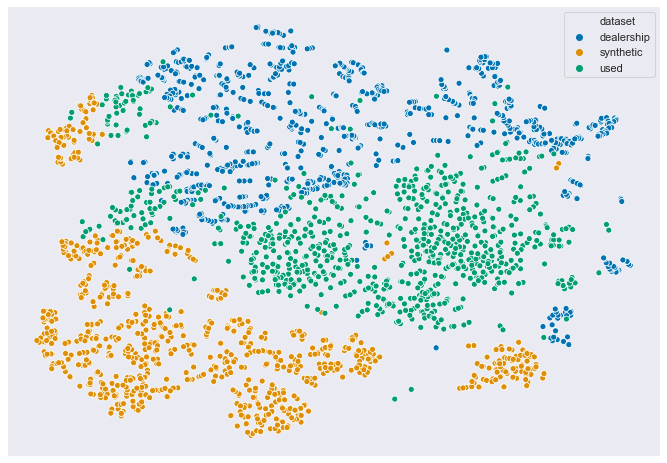

In [107]:
palette = sns.color_palette("colorblind", 3)
ax = sns.scatterplot(data=df, x='tsne0', y='tsne1', hue='dataset', legend='full', palette=palette)
ax.set(xlabel='', ylabel='', xticks=[], yticks=[]);

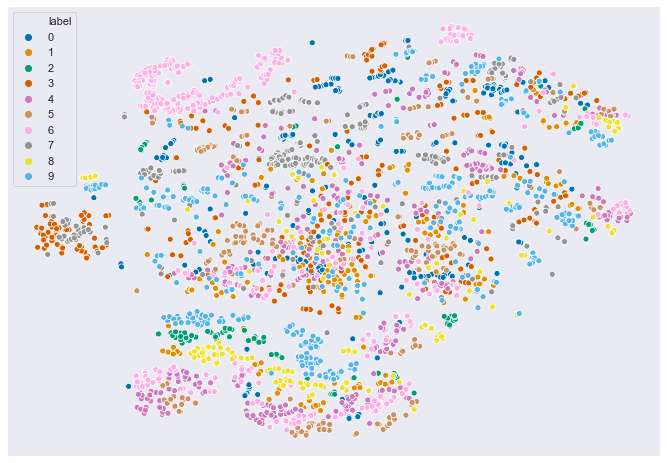

In [48]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df, x='tsne0', y='tsne1', hue='label', legend='full', palette=palette)
ax.set(xlabel='', ylabel='', xticks=[], yticks=[]);

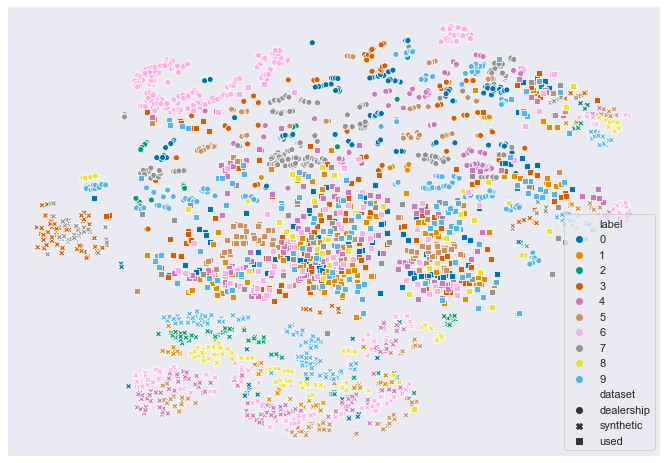

In [49]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df, x='tsne0', y='tsne1', hue='label', legend='full', palette=palette, style='dataset')
ax.set(xlabel='', ylabel='', xticks=[], yticks=[]);

### Finetuned ResNet 50 feature extractor (ERM)

In [73]:
load_dict = torch.load(os.path.join('../sweeps/daimler-erm/test-0/model.pkl'))
featurizer_dict = {k[19:]: v for k, v in load_dict['model_dict'].items() if k[:19] == 'featurizer.network.'}
network.load_state_dict(featurizer_dict)
dataloader_iterator = iter(dataloader)

In [77]:
network.eval()
for step in tqdm(range(len(dataloader))):
    input, target = next(dataloader_iterator)
    features = network(input)
    with open('features_erm.pickle', 'ab') as f:
        pickle.dump(features, f)

In [117]:
all_features = []
with open('features_erm.pickle', 'rb') as f:
    try:
        while True:
            all_features.append(pickle.load(f))
    except EOFError:
        pass
all_features = torch.cat(all_features)
all_features = all_features.detach().numpy()

In [118]:
tsne = TSNE()
all_features_embedded = tsne.fit_transform(all_features)

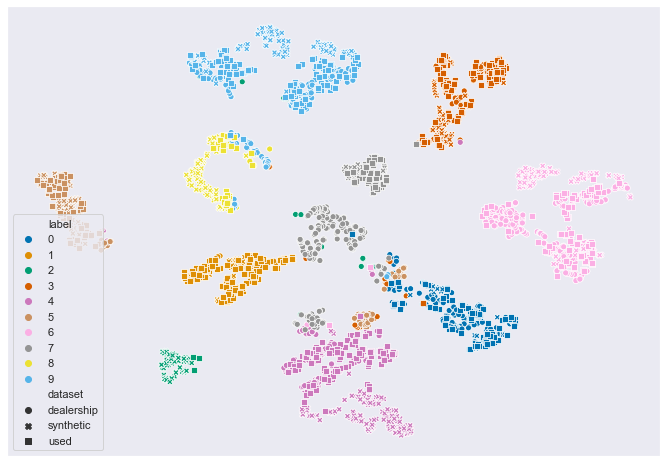

In [119]:
df['tsne0'] = all_features_embedded[:,0]
df['tsne1'] = all_features_embedded[:,1]
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df, x='tsne0', y='tsne1', hue='label', legend='full', palette=palette, style='dataset')
ax.set(xlabel='', ylabel='', xticks=[], yticks=[]);

### Finetuned ResNet 50 feature extractor (DANN)

In [92]:
load_dict = torch.load(os.path.join('../sweeps/daimler-erm/test-0/model.pkl'))
featurizer_dict = {k[19:]: v for k, v in load_dict['model_dict'].items() if k[:19] == 'featurizer.network.'}
network.load_state_dict(featurizer_dict)
dataloader_iterator = iter(dataloader)

In [93]:
network.eval()
for step in tqdm(range(len(dataloader))):
    input, target = next(dataloader_iterator)
    features = network(input)
    with open('features_dann.pickle', 'ab') as f:
        pickle.dump(features, f)

In [108]:
all_features = []
with open('features_dann.pickle', 'rb') as f:
    try:
        while True:
            all_features.append(pickle.load(f))
    except EOFError:
        pass
all_features = torch.cat(all_features)
all_features = all_features.detach().numpy()

In [109]:
tsne = TSNE()
all_features_embedded = tsne.fit_transform(all_features)

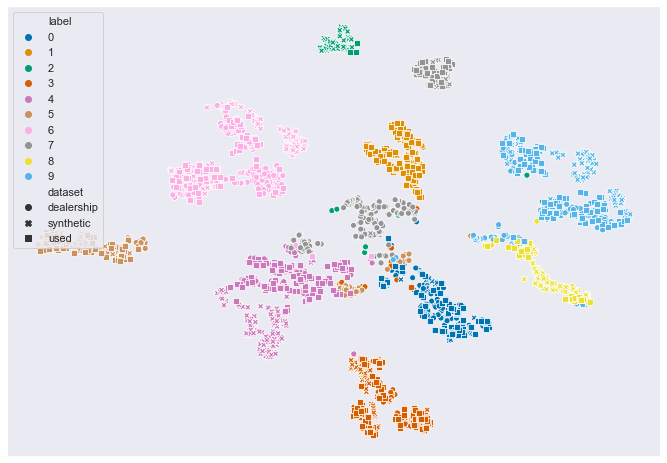

In [115]:
df['tsne0'] = all_features_embedded[:,0]
df['tsne1'] = all_features_embedded[:,1]
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df, x='tsne0', y='tsne1', hue='label', legend='full', palette=palette, style='dataset')
ax.set(xlabel='', ylabel='', xticks=[], yticks=[]);